In [2]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial
from scipy.optimize import minimize, differential_evolution, basinhopping
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from Nexis_model_forward import run_Nexis
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap


## Preparing Inputs

In [3]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Define total number of subcortical regions and cortical regions per hemisphere
total_sub = 9 - len(regions_to_exclude)/2
total_cor = 34

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

Top seed regions: ['ctx-lh-inferiortemporal' 'ctx-rh-inferiortemporal'
 'Left-Cerebellum-Cortex' 'Left-Thalamus-Proper' 'Left-Hippocampus']


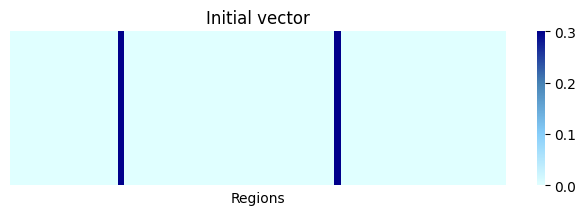

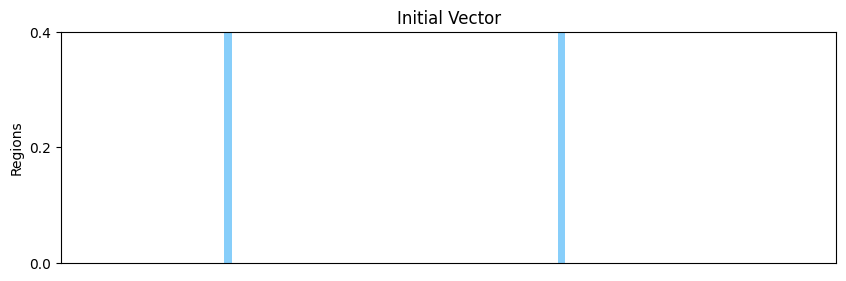

In [6]:
# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'binary' 

# Conversion of ADNI region order to match connectivity matrix
ADNI_to_norm = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Upload EBM time series
EBM_data = pandas.read_csv('EBM time series/EBM time series - version 9 final run.csv')
# with tmax: EBM time series - version 9.csv (old final)
# without tmax: EBM time series - version 9 final run.csv (FINAL)

EBM_data = EBM_data.drop('Unnamed: 0', axis=1)

# Normalize by mean at t=0
# t0_mean = EBM_data.iloc[0].mean()
# EBM_data = EBM_data / t0_mean 
# EBM_data = EBM_data / 10

# Reorder regions to match region order of connectivity matrix
EBM_data_reordered = EBM_data.iloc[:, ADNI_to_norm]

 # Delete striatal regions 
columns_to_delete = EBM_data_reordered.columns[excluded_indices]
EBM_data_excluded = EBM_data_reordered.drop(columns_to_delete, axis = 1)

# OPTION 1: Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    # Take the first row (time point 0) as initial vector
    # EBM BASELINE
    #init_vec = EBM_data_excluded.iloc[0].values 

    # seed op 1 (old final, new final)
    #init_vec = np.array([0.0, 0.011972019088523035, 0.03255798559734351, 0.04113262225398453, 0.0285114670113035, 0.0, 0.009323747335994236, 0.031079640256422094, 0.04364763602187893, 0.028448537408073637, 0.012608522624998253, 0.0, 0.002080821608330986, 0.001156562720584788, 0.02319180054804144, 0.04503279906559312, 0.04503180105724704, 0.04831058441468627, 0.00022498797435731023, 0.006309352506959541, 0.02025604574631611, 0.0, 0.01033350360064145, 0.043801056960145406, 0.0, 0.0, 0.008834712916727829, 0.009171163648234533, 0.00792061839101299, 0.0, 0.0, 0.003960019184381009, 0.0, 0.036179484685018366, 0.0, 0.012111975218836828, 0.0036227451665061935, 0.0, 0.0059402924576300725, 0.010208748751285858, 0.0, 0.01623490876419933, 0.0, 0.007982251307321246, 0.00208658241018703, 0.0, 0.0012104263525968511, 0.004613901427095693, 0.025680699408833576, 0.04652598767813947, 0.042867685943331006, 0.04333192201080362, 0.0, 0.01801599603582735, 0.022567404282987393, 0.001718248356186273, 0.01547315319863985, 0.047599859092659264, 0.0, 0.0, 0.006035593078093779, 0.012009782745627338, 0.009787923684768832, 0.0, 0.0, 0.00030569650427701055, 0.0, 0.0430206707622025, 0.0, 0.016622754660739612, 0.0061139850024569155, 0.0, 0.00037053770555973845, 0.0002099082026774811, 0.0, 0.013428306421510765, 0.0, 0.008197293723819804])
    #init_vec = np.array([0.0, 0.0, 0.1797912692781644, 0.3112351054181414, 0.0, 0.0, 0.017350048914301083, 0.11504920936757412, 0.30358564023811474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3855030378638843, 0.30657034607850436, 0.1613672211107048, 0.0, 0.0, 0.1305544150141248, 0.0, 0.021326554743881357, 0.4231532891750418, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17170024927971667, 0.0, 0.07424694031891696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02428139959456519, 0.41522338559802396, 0.302987767026093, 0.19187336331884614, 0.0, 0.0, 0.1304738518516531, 0.0, 0.03436054670019505, 0.28192517342399637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24776075268686057, 0.0, 0.09261264411068271, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

    # seed op 2
    #init_vec = np.array([0.0, 0.0060005247900180025, 0.022382584771766422, 0.04165150868975457, 0.012485078559192, 0.0, 0.004473459323546373, 0.024747104460103767, 0.03941558227225127, 0.007014556459100195, 0.02165934017415148, 0.0, 0.0018362216809406054, 0.0, 0.028034180985145103, 0.047699398442968506, 0.055555801767342636, 0.04483853079921314, 0.0, 0.00744047967921105, 0.02180448859167293, 0.0, 0.011395178825146752, 0.05123843234271144, 0.0, 0.0, 0.008657343041935491, 0.0033528578903020026, 0.004203763258589289, 0.0, 0.0, 0.0014664999730561032, 0.0, 0.03627058372067787, 0.0, 0.013538241453927253, 0.0024441019887415302, 0.0, 0.000527551699899108, 0.007545639807151222, 0.0, 0.01807021758369868, 0.0, 0.0016993876300651894, 0.002058419993635963, 0.0, 0.0025684371002993103, 0.00256607065073539, 0.024638246776311448, 0.04917964365752034, 0.04544349722905243, 0.03838555484555343, 0.0, 0.011708866703643087, 0.022517449633252525, 0.0, 0.013976687416284946, 0.05229556292734267, 0.0, 0.0, 0.004995909772007561, 0.0072878758070222425, 0.004905953332137077, 0.0, 0.0, 0.0, 0.0, 0.044544426489892285, 0.0, 0.016992645474940803, 0.0027449015765960384, 0.0, 0.0, 0.0, 0.0, 0.014488347227436912, 0.0, 0.002875374554815552])
    init_vec = np.array([0.0, 0.0, 0.1514586323573524, 0.42836151855090715, 0.0, 0.0, 0.0017402925507693555, 0.0, 0.24759116345760815, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12175048976781688, 0.15091551647443133, 0.29918278428170814, 0.0, 0.0, 0.12250147328025895, 0.0, 0.0, 0.3482878378043656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21530186438848417, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3627763979992332, 0.09081189212670127, 0.25426856912772555, 0.38861161764821844, 0.0, 0.011012838241325843, 0.12067612758145085, 0.0, 0.0, 0.21179516355228645, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01639841292541576, 0.0, 0.024597765319579586, 0.08323582650742528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    
    use_baseline_ = 1

#OPTION 2: Binary vector indicating seeding location 
if init_vec_method == 'binary':

    seeding_locations = ['ctx-lh-inferiortemporal', 'ctx-rh-inferiortemporal'] # MANUALLY EDIT SEEDING LOCATION HERE
    seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding locations to 1 (both left and right hemisphere)
    init_vec[seeding_indices[0]] = 1 
    init_vec[seeding_indices[1]] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

# Print highest tau seed regions
top_seed_values = sorted(init_vec, reverse=True)[:5]
top_indices = sorted(range(len(init_vec)), key=lambda i: init_vec[i], reverse=True)[:5]
regions_array = np.array(regions)
top_seeds = regions_array[top_indices]
print('Top seed regions: ' + str(top_seeds))

blue_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#E0FFFF", "#87CEFA", "#4682B4", "#00008B"])

# Plot initial vector as heatmap
plt.figure(figsize=(8, 2)) 
init_vec_reshaped = init_vec.reshape((78,1))
sns.heatmap(init_vec_reshaped.T, cmap=blue_cmap, xticklabels=False, yticklabels=False, vmax = 0.3)
plt.xlabel('Regions')
plt.title('Initial vector')

# As bar chart
plt.figure(figsize=(10, 3))
plt.ylim(0, 0.4)
plt.xlim(0, 79)
num_y_ticks = 3  # You can adjust this number
y_tick_locations = np.linspace(0, 0.4, num_y_ticks)
plt.yticks(y_tick_locations)
plt.bar(np.arange(len(init_vec)), init_vec, color= '#87CEFA')
plt.title('Initial Vector')
plt.ylabel('Regions')
plt.xticks([])
plt.show()

In [581]:
# Calculate intial vector sparsity

def energy_calc(seed): 
    seed = np.array(seed)
    seed_ordered = np.sort(seed)[::-1]
    seed_sum = seed.sum()
    percent_of_sum = seed_sum * 0.9

    temp_sum = 0
    for value in seed_ordered:
        temp_sum = temp_sum + value
        if temp_sum > percent_of_sum:
            threshold = value
            print('Threshold: ' + str(threshold))
            count_sparse_regions = np.sum(seed > threshold)
            print('Regions above threshold (regions that contribute to 90% of total seed energy): ' + str(count_sparse_regions))
            return
        
energy_calc(init_vec)

Threshold: 1.0
Regions above threshold (regions that contribute to 90% of total seed energy): 0


In [582]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Reorder to match that of connectivity matrix
DK_to_norm = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[DK_to_norm, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [595]:
# Run on either individual subjects (1) or whole cohort (0) (SET HERE)
individual = 1

In [603]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1))  # Don't care about cell types (nROI x nTypes), set to nROI x 1 array of random numbers or 0
init_vec_ = init_vec # Initial tau vector (nROI x 1)
if individual == 1:
    t_vec_ = np.linspace(0, 18, 19)
else:
    t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
degreecorrect_ = 0 # Binary flag indicating whether to normalize by degree (for Ashish, normally set this to 0)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without

## Load EBM Data

In [585]:
if individual == 1:
    patient_data = pandas.read_csv('EBM stage + tau/Stage + tau - version 9 final run.csv')
    # with tmax: Cross-sectional stage and regional tau - version 9.csv (current final)
    # without tmax: Stage + tau - version 9 final run (testing final)

    RID = 69	#EDIT PATIENT RID MANUALLY HERE Figure 3: 69, 6142, 4414
    patient = patient_data[patient_data['RID'] == RID] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]
    # LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, ADNI_to_norm]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

else:
    # Convert to an nROI x 100 array and transpose
    EBM_data_array = EBM_data_excluded.values
    EBM_data_transposed = EBM_data_array.T
    
    # Normalize by L2 norm
    #normalized_EBM_data_excluded = normalize_by_l2_norm(EBM_data_excluded)

## Parameter Optimization

In [586]:
# Define cost function 
def Nexis_error(params, patient_tau):
    
    param1, param2, param3, param4, param5, param6, param7 = params 
    # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 =k
    
   # Initialize run_Nexis object 
    nexis_optimizing = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_ = logistic_term_)

    # Parameters for simulate_nexis method
    parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

    # Call the simulate_nexis method with the parameters
    Y = nexis_optimizing.simulate_nexis(parameters)

    if individual == 1:
        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages] 

        # Check if Y_edited is constant
        if np.all(Y_edited == Y_edited[0]):
            Y_edited[0] = Y_edited[0] + 0.00001 # Add small constant 
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        error = mse_matrix(patient_tau, Y_edited) + 0.5 * (1- corr_coeff) 
    
    else:
        # Fit to EBM interpolation
        corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
        error = mse_matrix(EBM_data_transposed, Y) + 0.5 * (1- corr_coeff)
    
    return error

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.14321618185068452, 3.9999375770533403, 1.0, 0.5, 0.0, 0.0, 1000.0]
Final error (value of objective function): 1.1273354864955842


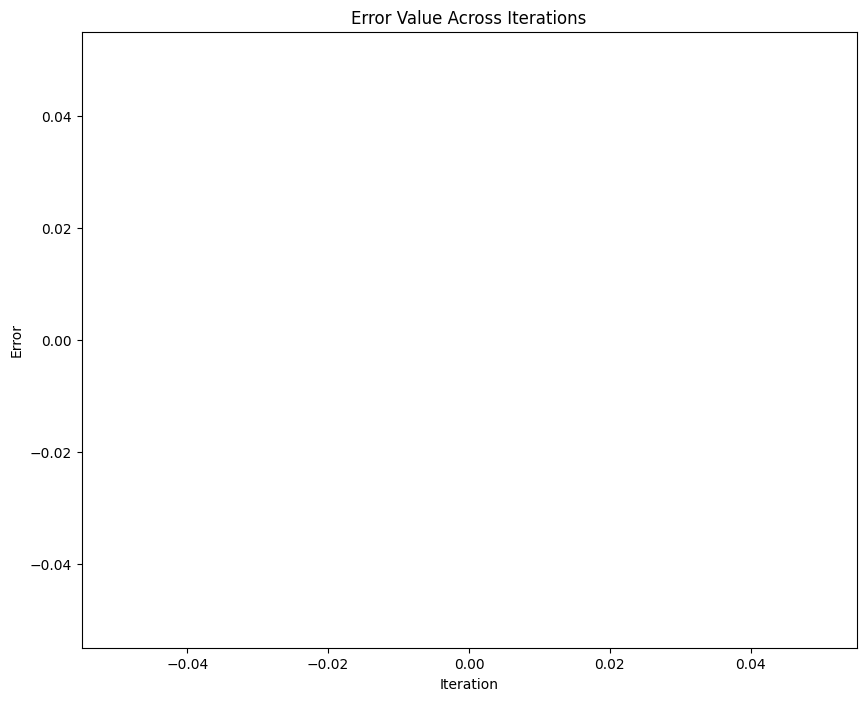

In [604]:
# Save error values to plot
error_values = []
def callback(params):
    error = Nexis_error(params, patient_tau)
    error_values.append(error)

custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

# Initial guesses for parameters (alpha, beta, gamma, s, b, p, k) # ADJUST THESE
init_guess = np.array([0.2, 1.01, 1, 0.5, 0, 0, 1000])

# Bounds for each parameter [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. # ADJUST THESE
bounds = [(0, 3),(0, 4),(1,1),(0.5,0.5),(0,0),(0,0),(1000,1000)]

# Perform the optimization
result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='Powell', options={'xtol': 1e-4, 'ftol': 1e-4,'maxiter': 1000}) # Methods: Powell OR L-BFGS-B
#result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='L-BFGS-B',options={'disp': True, 'maxiter': 1000}, callback=callback)

if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist()
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
    print(f"Final error (value of objective function): {result.fun}")
else:
    print("Optimization failed.", result.message)
    print(f"Final error (value of objective function): {result.fun}")

# Plot error values across iterations
plt.figure(figsize=(10, 8))
plt.plot(range(len(error_values)), error_values, marker='o', linestyle='-', linewidth= 3, color='#6B8E23')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error Value Across Iterations')
plt.show()

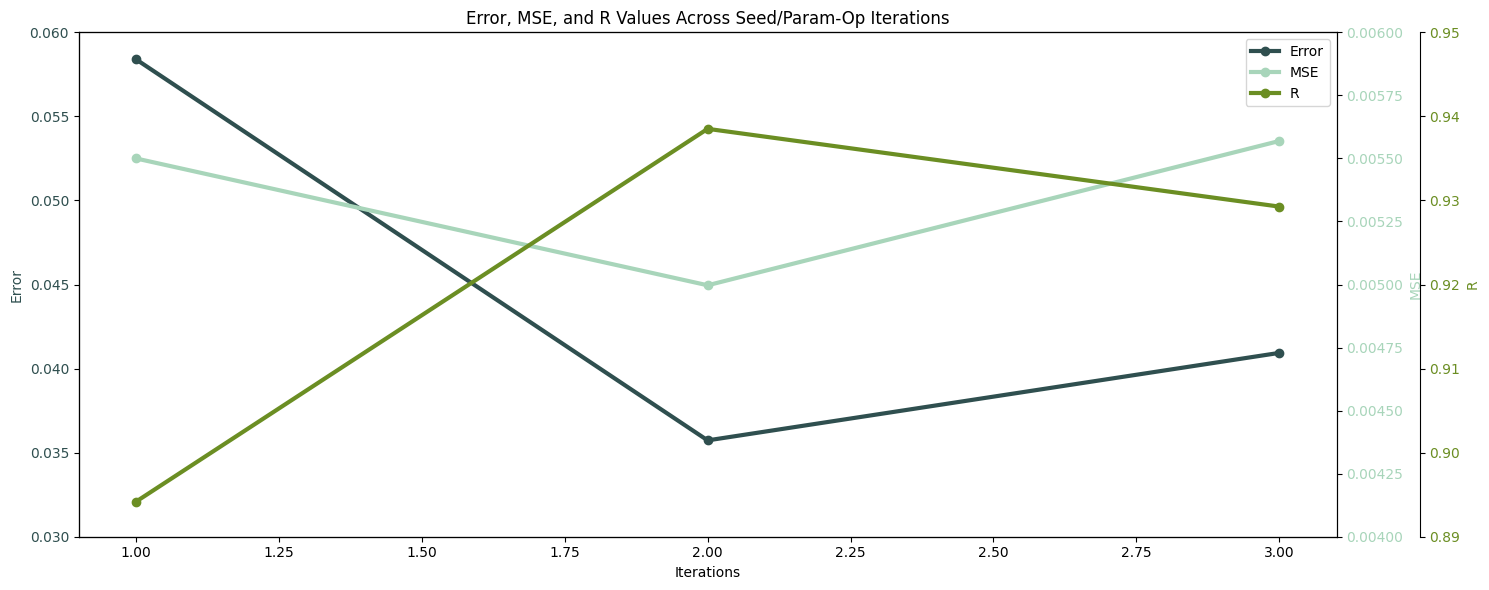

In [579]:
# TEMP: Plot objective function error across iterations
error_iter = np.array([0.058397, 0.03573, 0.0409345091])
R_iter = [0.894166, 0.93852, 0.929269]
MSE_iter = [0.0055, 0.004997, 0.00556923]
iterations = np.array([1, 2, 3])

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Error
line1 = ax1.plot(iterations, error_iter, marker='o', linestyle='-', linewidth=3, color='#2F4F4F', label='Error')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Error', color='#2F4F4F')
ax1.tick_params(axis='y', labelcolor='#2F4F4F')
err_min, err_max = 0.03, 0.06
ax1.set_ylim(err_min, err_max)

# Plot MSE
ax2 = ax1.twinx()
line2 = ax2.plot(iterations, MSE_iter, marker='o', linestyle='-', linewidth=3, color='#A8D5BA', label='MSE')
ax2.set_ylabel('MSE', color='#A8D5BA')
ax2.tick_params(axis='y', labelcolor='#A8D5BA')
mse_min, mse_max = 0.004, 0.006
ax2.set_ylim(mse_min, mse_max)

# Plot R
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outward
line3 = ax3.plot(iterations, R_iter, marker='o', linestyle='-', linewidth=3, color='#6B8E23', label='R')
ax3.set_ylabel('R', color='#6B8E23')
ax3.tick_params(axis='y', labelcolor='#6B8E23')
r_min, r_max = 0.89, .95
ax3.set_ylim(r_min, r_max)

# Add a title
plt.title('Error, MSE, and R Values Across Seed/Param-Op Iterations')

# Add legend
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [214]:
# TESTING (looping through different initial guesses and trying different optimization algorthyms)

from scipy.optimize import minimize, differential_evolution, basinhopping

def safe_objective(params):
    try:
        print("Input parameters:", params)
        result = custom_Nexis_error(params)  # Your original objective function
        print("Result:", result)
        if np.isinf(result) or np.isnan(result):
            print("Warning: Infinite or NaN result")
            return 1e10  # A large, finite number
        return result
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1e10  # A large, finite number

# Check input data
print("Any NaN in patient_tau:", np.isnan(patient_tau).any())
print("Any inf in patient_tau:", np.isinf(patient_tau).any())

# Parameter bounds
bounds = [(0, 2), (0, 3), (1, 1), (0.5, 0.5), (0, 0), (0, 0), (50, 50)]

# Multiple starting points
initial_guesses = [
    [0.1, 0.1, 1.0, 0.5, 0, 0.0, 50],
    [0.5, 0.5, 1.0, 0.5, 0, 0.0, 50],
    [1, 1, 1.0, 0.5, 0, 0.0, 50]
]
# Global optimization using Differential Evolution
de_result = differential_evolution(safe_objective, bounds, strategy='best1bin', 
                                   popsize=15, tol=0.01, mutation=(0.5, 1), 
                                   recombination=0.7, seed=None, maxiter=1000, 
                                   polish=True)

# Global optimization using Basin-hopping
bh_result = basinhopping(safe_objective, initial_guesses[0], niter=100, T=1.0, 
                         stepsize=0.5, minimizer_kwargs={'method': 'L-BFGS-B', 'bounds': bounds})

# Compare results
results = [de_result, bh_result]
best_overall = min(results, key=lambda x: x.fun)

print(f"Best parameters: {best_overall.x}")
print(f"Best objective value: {best_overall.fun}")


Any NaN in patient_tau: False
Any inf in patient_tau: False
Input parameters: [ 0.58089993  2.43484108  1.          0.5         0.          0.
 50.        ]
Result: 313.7616584374284
Input parameters: [ 0.91869775  0.26986485  1.          0.5         0.          0.
 50.        ]
Result: 921.7893360235802
Input parameters: [ 1.23968666  0.60328195  1.          0.5         0.          0.
 50.        ]
Result: 1274.3498636421577
Input parameters: [ 1.47652553  1.95290723  1.          0.5         0.          0.
 50.        ]
Result: 1438.950973826347
Input parameters: [ 0.41374369  0.49015164  1.          0.5         0.          0.
 50.        ]
Result: 68.3657161625022
Input parameters: [ 0.26368903  1.02685071  1.          0.5         0.          0.
 50.        ]
Result: 4.1496981577364815
Input parameters: [ 1.99760799  1.74762803  1.          0.5         0.          0.
 50.        ]
Result: 1661.021687416797
Input parameters: [ 1.78576474  2.24428609  1.          0.5         0.        

## Running Nexis

Pearsons R: -0.003309203633766987
Mean squared error: 0.6256808846787009
Final error: 1.1273354864955842


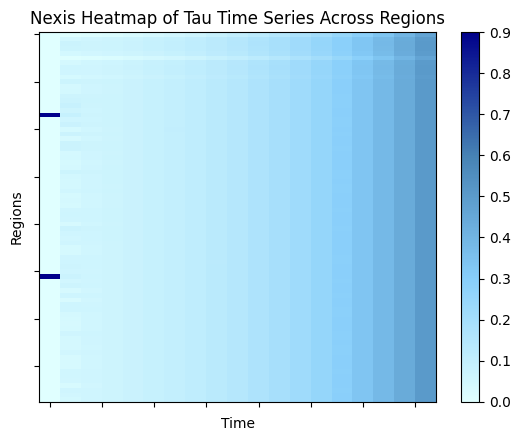

In [605]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_)

# Parameters for simulate_nexis method
parameters = optimized_params  # [alpha, beta, gamma, s, b, p, k] 
# parameters = [, 1, 0.5, 0, 0, 50] # CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

if individual == 1:
    Y_edited = Y[:, stages] # Take stages from Y that correspond to patient's stages 
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
    mse = mse_matrix(patient_tau, Y_edited)
    final_error = mse + 0.5 * (1- corr_coeff)
else:
    normalized_Y = normalize_by_l2_norm(Y) # Normalize by L2 norm
    corr_coeff, p_value = pearsonr(EBM_data_transposed.flatten(), Y.flatten())
    mse = mse_matrix(EBM_data_transposed, Y)
    final_error = mse + 0.5 * (1- corr_coeff)
    
print('Pearsons R: ' + str(corr_coeff))
print('Mean squared error: ' + str(mse))
print('Final error: ' + str(final_error))

# Plot heatmap of Y
plt.imshow(Y, cmap=blue_cmap, interpolation='none', aspect='auto', vmax = 0.9)
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Nexis Heatmap of Tau Time Series Across Regions')
plt.xlabel('Time')  
plt.ylabel('Regions')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])

for spine in ax.spines.values():
    spine.set_visible(True)


## Check Results

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1346/2484205604.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5, linestyle = '--')


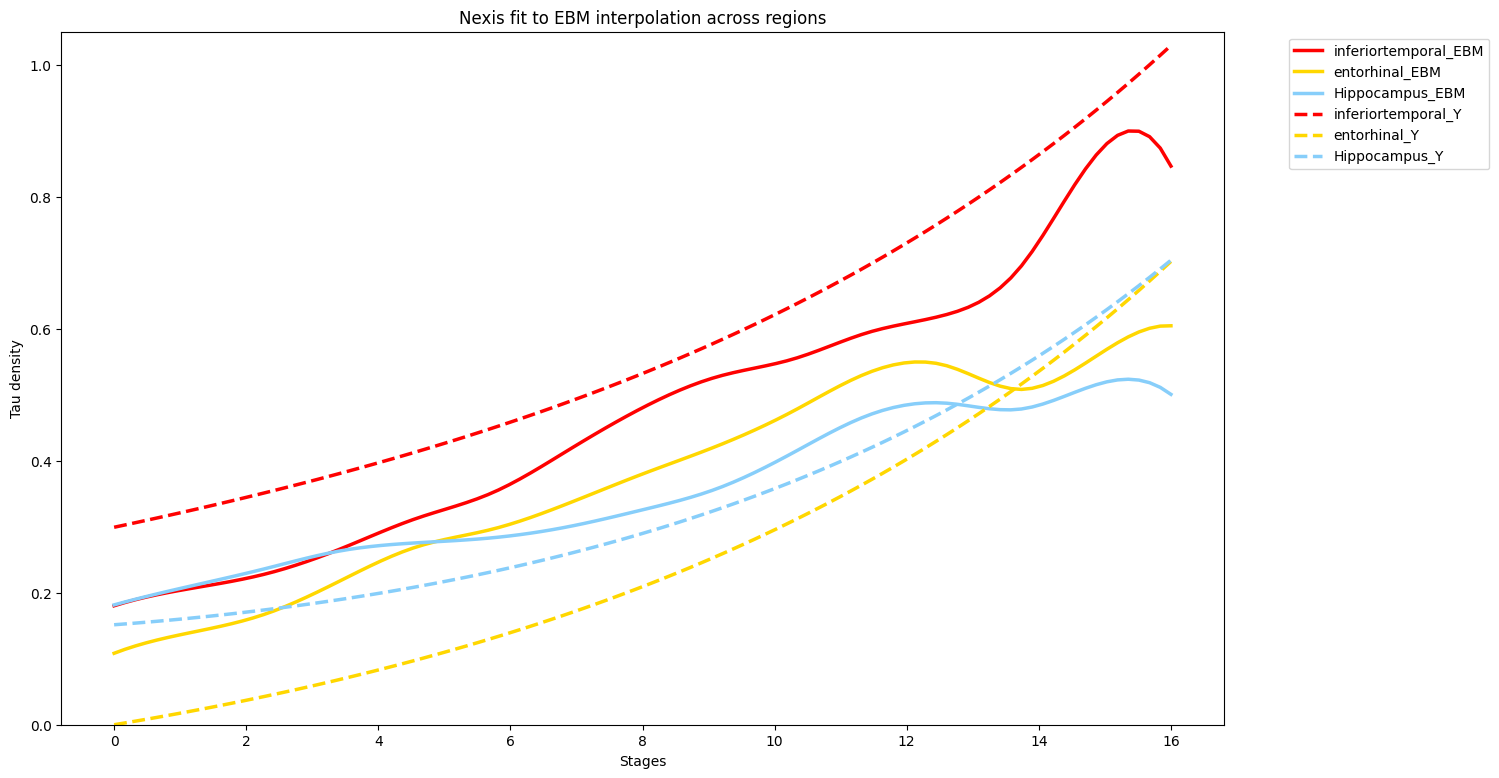

In [500]:
# Plot regions of Y against those region in EBM regional interpolations

Y_for_figure = pandas.DataFrame(Y)
Y_for_figure = Y_for_figure.T
Y_for_figure.columns = regions
Y_for_figure = Y_for_figure[['ctx-lh-inferiortemporal','ctx-lh-entorhinal','Left-Hippocampus']]
Y_for_figure = Y_for_figure.rename(columns={'ctx-lh-inferiortemporal': 'inferiortemporal_Y', 'ctx-lh-entorhinal': 'entorhinal_Y', 'Left-Hippocampus': 'Hippocampus_Y'})

EBM_for_figure = pandas.DataFrame(EBM_data_transposed)
EBM_for_figure = EBM_for_figure.T
EBM_for_figure.columns = regions
EBM_for_figure = EBM_for_figure[['ctx-lh-inferiortemporal','ctx-lh-entorhinal','Left-Hippocampus']]
EBM_for_figure = EBM_for_figure.rename(columns={'ctx-lh-inferiortemporal': 'inferiortemporal_EBM', 'ctx-lh-entorhinal': 'entorhinal_EBM', 'Left-Hippocampus': 'Hippocampus_EBM'})

for_figure = pandas.merge(EBM_for_figure,Y_for_figure,left_index=True, right_index=True)

plt.figure(figsize=(15, 9))
plt.ylim(0, 1.05)
colors = ['#FE0101', '#FFD700', '#87CEFA'] #'#FE0101', '#FFD700', '#00008B', '#FA8072', '#FFFF66', '#87CEFA'
xnew = np.linspace(0, 16, 100) 

for idx, (col, color) in enumerate(zip(for_figure.columns[0:3], colors)):
    col_data = for_figure[col]
    plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5)

for idx, (col, color) in enumerate(zip(for_figure.columns[3:6], colors)):
    col_data = for_figure[col]
    plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5, linestyle = '--')

# Remove tick labels but keep ticks
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)

# Keep axis labels
plt.title('Nexis fit to EBM interpolation across regions')
plt.xlabel('Stages')
plt.ylabel('Tau density')

# Show the plot
plt.show()


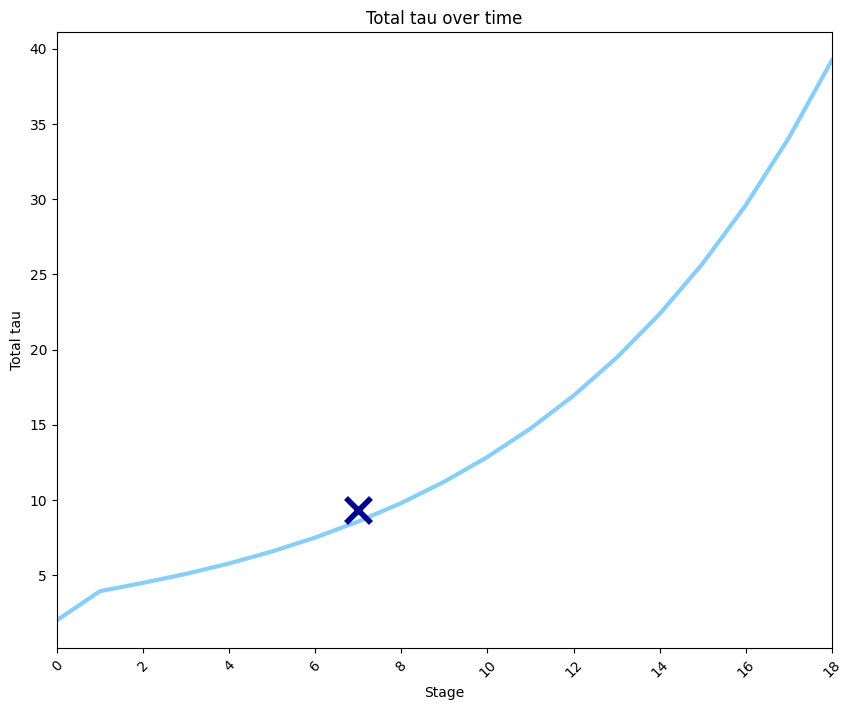

In [606]:
# regional_volumes_array = np.array(regional_volumes_excluded)
# regional_volumes_array = regional_volumes_array.reshape((78,1))
# tau_mass_Y = regional_volumes_array * Y
# total_tau_Y = np.sum(tau_mass_Y, axis=0)
total_tau_Y = np.sum(Y, axis=0)

if individual == 1:
    # Volume correction
    patient_tau = patient_tau.reshape(78,1)
    #tau_mass_patient = regional_volumes_array * patient_tau
    #total_tau_patient = np.sum(tau_mass_patient, axis=0)
    total_tau_patient = np.sum(patient_tau, axis=0)

    time_points_Y = np.linspace(0, 18, 19)
    plt.figure(figsize=(10, 8))
    plt.xlim(0,18)

    # Plot total_tau_Y
    plt.plot(time_points_Y, total_tau_Y, linestyle='-', linewidth = 3, color='#87CEFA', label= 'Y')  

    # Plot total_tau_patient on the same graph
    plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='#00008B', label= 'patient', markersize=18, markeredgewidth=4)

    plt.title('Total tau over time') 
    plt.xlabel('Stage')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    #plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show
    
else:
    # Plot total tau over time to compare the scales of EBM and Y
    # EBM_mass = regional_volumes_array * EBM_data_excluded
    # EBM_total_tau = np.sum(EBM_mass, axis=1)
    EBM_total_tau = np.sum(EBM_data_excluded, axis=1)

    time_points = np.linspace(0, 99, 100)

    plt.figure(figsize=(10, 6))

    # Plot total_tau_Y
    #plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  
    plt.plot(time_points, total_tau_Y, linestyle='--', color='k', label= 'Y')  

    # Plot EBM interpolation on the same graph
    plt.plot(time_points, EBM_total_tau, linestyle='-', color='k', label= 'EBM')

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    #plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show

## Loop Through All Subjects 
If running on individuals

In [607]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

#Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE', 'R', 'alpha', 'beta', 'gamma', 's', 'b', 'p', 'k']
parameters_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, ADNI_to_norm]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Check for NaN or inf values in patient_tau
    if np.isnan(patient_tau).any() or np.isinf(patient_tau).any():
        print(f"Skipping RID {rid} due to NaN or inf values in patient_tau")
        continue

    # Perform the optimization
    custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

    result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='Powell', 
                    options={'xtol': 1e-3, 'ftol': 1e-3, 'maxiter': 1000})
    
    if result.success:
        optimized_params = result.x
        optimized_params = optimized_params.tolist()

        # Run Nexis    
        Y = nexis_model.simulate_nexis(optimized_params) 
        Y_edited = Y[:, stages]

        # Check for NaN or inf values in Y_edited
        if np.isnan(Y_edited).any() or np.isinf(Y_edited).any():
            print(f"Skipping RID {rid} due to NaN or inf values in Y_edited")
            continue
        
        # Calculate MSE and R
        mse = mse_matrix(patient_tau, Y_edited)
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        
        # Create data frame for the subject
        parameters = pandas.DataFrame([[rid] + [mse] + [corr_coeff] + optimized_params], columns=column_names)

        # Concatenate the original DataFrame with the new DataFrame
        parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)

parameters_all

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1346/1590229364.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)


,RID,MSE,R,alpha,beta,gamma,s,b,p,k
0,21,0.048411,-0.034045,2.999493,3.999641,1.0,0.5,0.0,0.0,1000.0
1,31,0.032626,-0.002805,2.999493,3.999641,1.0,0.5,0.0,0.0,1000.0
2,56,0.049110,0.014799,2.999493,3.999641,1.0,0.5,0.0,0.0,1000.0
3,59,0.056212,0.137594,0.660369,1.330909,1.0,0.5,0.0,0.0,1000.0
4,69,0.057774,0.116671,0.646017,1.149955,1.0,0.5,0.0,0.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
645,6704,0.017138,0.082700,0.626174,1.806548,1.0,0.5,0.0,0.0,1000.0
646,6705,0.628156,-0.000489,0.099983,3.999999,1.0,0.5,0.0,0.0,1000.0
647,6713,0.050181,-0.004506,2.999493,3.999641,1.0,0.5,0.0,0.0,1000.0
648,6721,0.057777,0.125171,0.613395,1.168230,1.0,0.5,0.0,0.0,1000.0


In [608]:
# Add diagnosis and ml_stage information to data frame
parameters_all.insert(1, 'Diagnosis', patient_data['Diagnosis'])
parameters_all.insert(2, 'ml_stage', patient_data['ml_stage'])

# Save to a csv 
parameters_all.to_csv('seed vs. param op/Optimized param - canonical inferiortemporal.csv')